In [9]:
from nltk.corpus import stopwords

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn

import matplotlib.pyplot as plt

# импортируем трансформеры
import transformers
import warnings
warnings.filterwarnings('ignore')
from torchmetrics.classification import BinaryF1Score, AUROC
from time import time
from sklearn.metrics import f1_score, precision_recall_curve, roc_auc_score


In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\safar\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [8]:
stop_words = set(stopwords.words("russian"))

In [11]:
path = 'labeled(1).csv'
df = pd.read_csv(path)
df.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [12]:
df["toxic"].value_counts()

toxic
0.0    9586
1.0    4826
Name: count, dtype: int64

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
# Проверка средней длинны предложения в датасете

test = df['comment'].apply(lambda x: len(x.split()))
test.describe()

count    14412.000000
mean        27.946017
std         41.432218
min          1.000000
25%          9.000000
50%         16.000000
75%         32.000000
max       1078.000000
Name: comment, dtype: float64

#### Загрузка предобученной модели и токенизатора

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny-toxicity")
model = AutoModelForSequenceClassification.from_pretrained("cointegrated/rubert-tiny-toxicity")  

#### Функция для оценки токсичности текста

In [16]:
def text2toxicity(text, aggregate=True):
    """ Calculate toxicity of a text (if aggregate=True) or a vector of toxicity aspects (if aggregate=False)"""
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
        proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()
    if isinstance(text, str):
        proba = proba[0]
    if aggregate:
        return 1 - proba.T[0] * (1 - proba.T[-1])
    return proba


#### Токенайзер
##### Токенизируем все комментарии с максимальной длиной 50 токенов

In [17]:
batch_size = 128

def tokenize_texts(texts, seq_len=50):
    return tokenizer(texts, padding='max_length', max_length=seq_len, truncation=True, return_tensors="pt")

In [18]:
encodings = tokenize_texts(df["comment"].tolist())
labels = torch.tensor(df["toxic"].tolist())

#### Создание Dataset класса

In [19]:
class ToxicityDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

dataset = ToxicityDataset(encodings, labels)

# Разделяем данные на обучающую и валидационную выборки
train_ds, valid_ds = torch.utils.data.random_split(dataset, [0.8, 0.2])


#### Создание DataLoader

In [20]:
train_loader = torch.utils.data.DataLoader(train_ds, shuffle=False, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_ds, shuffle=False, batch_size=batch_size)

In [21]:
batch = next(iter(train_loader))
batch["input_ids"].shape, batch["labels"].shape

(torch.Size([128, 50]), torch.Size([128]))

#### Определение модели ToxicBert

In [22]:
class ToxicBert(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained('cointegrated/rubert-tiny-toxicity')
        for param in self.bert.parameters():
            param.requires_grad = False
        self.bert.classifier = nn.Linear(312, 1)
        for param in self.bert.classifier.parameters():
            param.requires_grad = True
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

# Замораживаем веса основной модели (param.requires_grad = False), чтобы не обновлять их во время обучения
# Заменяем последний классификационный слой на новый (линейный слой с 312 входвходами и 1 выходом)
# Размораживаем веса только этого нового слоя для обучения

#### Инициализация модели, оптимизатора и функций потерь

In [23]:
model = ToxicBert()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
metric = AUROC(task='binary').to(device)

#### Функция обучения

In [24]:
def train(
        epochs: int, 
        model: torch.nn.Module, 
        train_loader: torch.utils.data.DataLoader,
        valid_loader: torch.utils.data.DataLoader, 
        optimizer: torch.optim.Optimizer, 
        criterion, 
        metric
        ) -> tuple: 
    
    epoch_train_losses = []
    epoch_valid_losses = []
    epoch_train_metric = []
    epoch_valid_metric = []
    epoch_train_f1 = []  # Для хранения F1 на тренировочных данных
    epoch_valid_f1 = []  # Для хранения F1 на валидационных данных
    time_start = time()
    
    for epoch in range(epochs):
        # Тренировка
        model.train()
        train_preds = []
        train_true = []
        
        batch_losses = []
        batch_metric = []
        batch_f1 = []
        
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels.float())

            preds = torch.sigmoid(outputs)
            score = metric(preds, labels)
            
            # Для расчета F1
            binary_preds = (preds > 0.5).int()
            train_preds.extend(binary_preds.cpu().numpy())
            train_true.extend(labels.cpu().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
            batch_metric.append(score.item())
        
        # Рассчитываем F1 для эпохи
        train_f1 = f1_score(train_true, train_preds)
        epoch_train_f1.append(train_f1)
        epoch_train_losses.append(np.mean(batch_losses))
        epoch_train_metric.append(np.mean(batch_metric))

        # Валидация
        model.eval()
        valid_preds = []
        valid_true = []
        
        batch_losses = []
        batch_metric = []
        batch_f1 = []
        
        with torch.no_grad():
            for batch in valid_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].unsqueeze(1).to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels.float())

                preds = torch.sigmoid(outputs)
                score = metric(preds, labels)
                
                # Для расчета F1
                binary_preds = (preds > 0.5).int()
                valid_preds.extend(binary_preds.cpu().numpy())
                valid_true.extend(labels.cpu().numpy())
                
                batch_losses.append(loss.item())
                batch_metric.append(score.item())
        
        # Рассчитываем F1 для валидации
        valid_f1 = f1_score(valid_true, valid_preds)
        epoch_valid_f1.append(valid_f1)
        epoch_valid_losses.append(np.mean(batch_losses))
        epoch_valid_metric.append(np.mean(batch_metric))

        print(f'Epoch {epoch+1}') 
        print(f'train_loss: {epoch_train_losses[-1]:.4f} | val_loss: {epoch_valid_losses[-1]:.4f}')
        print(f'train_ROC-AUC: {epoch_train_metric[-1]:.4f} | val_ROC-AUC: {epoch_valid_metric[-1]:.4f}')
        print(f'train_F1: {epoch_train_f1[-1]:.4f} | val_F1: {epoch_valid_f1[-1]:.4f}')
        print(25*'==')

    training_time = time() - time_start
    return (epoch_train_losses, epoch_valid_losses, 
            epoch_train_metric, epoch_valid_metric,
            epoch_train_f1, epoch_valid_f1,
            training_time)


#### Запуск обучения и Визуализация результатов обучения


Epoch 1
train_loss: 0.4086 | val_loss: 0.3903
train_ROC-AUC: 0.8885 | val_ROC-AUC: 0.8968
train_F1: 0.6954 | val_F1: 0.7388
Epoch 2
train_loss: 0.3786 | val_loss: 0.3785
train_ROC-AUC: 0.9008 | val_ROC-AUC: 0.9015
train_F1: 0.7299 | val_F1: 0.7444
Epoch 3
train_loss: 0.3702 | val_loss: 0.3731
train_ROC-AUC: 0.9037 | val_ROC-AUC: 0.9038
train_F1: 0.7341 | val_F1: 0.7570
Epoch 4
train_loss: 0.3668 | val_loss: 0.3674
train_ROC-AUC: 0.9054 | val_ROC-AUC: 0.9052
train_F1: 0.7461 | val_F1: 0.7585
Epoch 5
train_loss: 0.3636 | val_loss: 0.3637
train_ROC-AUC: 0.9072 | val_ROC-AUC: 0.9065
train_F1: 0.7509 | val_F1: 0.7610
Epoch 6
train_loss: 0.3582 | val_loss: 0.3612
train_ROC-AUC: 0.9100 | val_ROC-AUC: 0.9075
train_F1: 0.7530 | val_F1: 0.7640
Epoch 7
train_loss: 0.3554 | val_loss: 0.3594
train_ROC-AUC: 0.9110 | val_ROC-AUC: 0.9082
train_F1: 0.7589 | val_F1: 0.7637
Epoch 8
train_loss: 0.3575 | val_loss: 0.3571
train_ROC-AUC: 0.9089 | val_ROC-AUC: 0.9092
train_F1: 0.7515 | val_F1: 0.7641
Epoch 9


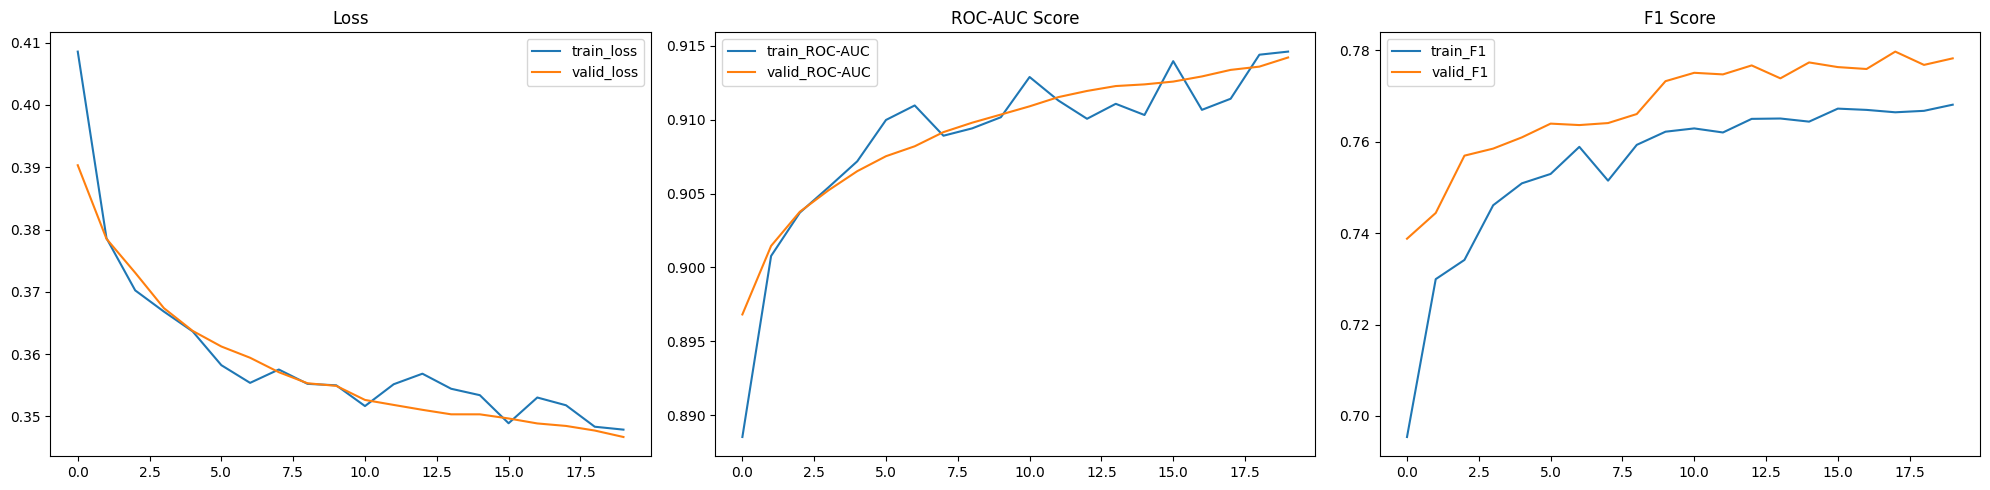

In [16]:
# После обучения получаем все метрики
(epoch_train_losses, epoch_valid_losses, 
 epoch_train_metric, epoch_valid_metric,
 epoch_train_f1, epoch_valid_f1,
 training_time) = train(epochs=20, model=model, 
                      train_loader=train_loader, 
                      valid_loader=valid_loader, 
                      optimizer=optimizer, 
                      criterion=criterion, 
                      metric=metric)

# Создаем графики
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# График Loss
ax[0].plot(epoch_train_losses, label='train_loss')
ax[0].plot(epoch_valid_losses, label='valid_loss')
ax[0].set_title('Loss')
ax[0].legend()

# График ROC-AUC
ax[1].plot(epoch_train_metric, label='train_ROC-AUC')
ax[1].plot(epoch_valid_metric, label='valid_ROC-AUC')
ax[1].set_title('ROC-AUC Score')
ax[1].legend()

# График F1 Score
ax[2].plot(epoch_train_f1, label='train_F1')
ax[2].plot(epoch_valid_f1, label='valid_F1')
ax[2].set_title('F1 Score')
ax[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
plt.savefig('metrics_and_loss_toxicity.jpg')

<Figure size 640x480 with 0 Axes>

#### Оценка модели на валидационной выборке

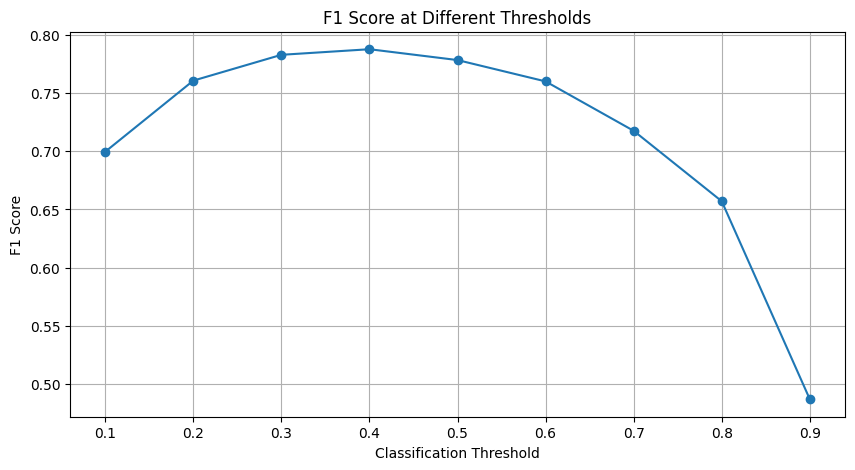

Best threshold: 0.40 with F1-score: 0.7876


In [18]:
model.eval()
all_labels = []
all_probs = []
all_preds = []

with torch.no_grad():
    for batch in valid_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()
        
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Рассчитываем F1 для разных порогов
thresholds = np.linspace(0.1, 0.9, 9)
f1_scores = []

for thresh in thresholds:
    preds = (np.array(all_probs) > thresh).astype(int)
    f1 = f1_score(all_labels, preds)
    f1_scores.append(f1)

# График F1 для разных порогов
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores, marker='o')
plt.title('F1 Score at Different Thresholds')
plt.xlabel('Classification Threshold')
plt.ylabel('F1 Score')
plt.grid()
plt.show()

# Выводим лучший порог
best_idx = np.argmax(f1_scores)
print(f'Best threshold: {thresholds[best_idx]:.2f} with F1-score: {f1_scores[best_idx]:.4f}')

# Анализ F1 для разных порогов: F1-score сильно зависит от выбранного порога классификации. Поиск оптимального порога может значительно улучшить качество модели

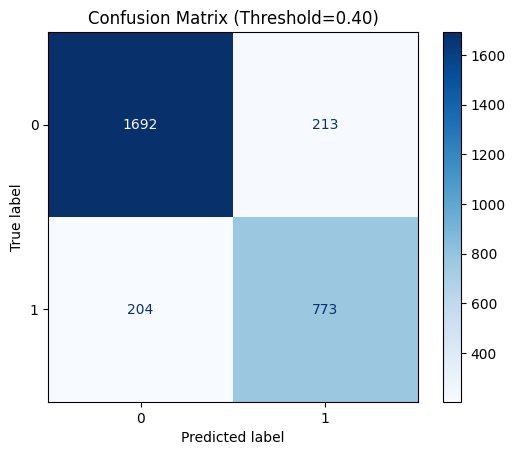

<Figure size 640x480 with 0 Axes>

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Используем оптимальный порог
optimal_threshold = thresholds[best_idx]
final_preds = (np.array(all_probs) > optimal_threshold).astype(int)

# Строим confusion matrix
cm = confusion_matrix(all_labels, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix (Threshold={optimal_threshold:.2f})')
plt.show()
plt.savefig('conf_matrix_toxicity.jpg')


#### Сохранение модели

In [20]:
torch.save(model.state_dict(), 'toxic_bert.pt')